- The following codes are for the Kaggle test: Toxic Comment Classification Challenge.
- Description: "In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. You’ll be using a dataset of comments from Wikipedia’s talk page edits. 
- Dataset: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
- Approach: CNN with 3 convolutional layers, 3 pooling layers and 1 dense layer

In [9]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from sklearn.metrics import roc_auc_score

In [4]:
# Configuration
max_sequence_length = 100 # for sequence padding
max_vocab_size = 20000 
embedding_dim = 100 # word embedding size
validation_split = 0.2 # proportion of validation set in training dataset
batch_size = 128
epochs = 10

In [7]:
# Prepare word embedding
# glove pretrained word embedding
# word vectors can be downloaded from "http://nlp.stanford.edu/data/glove.6B.zip"
# load in pre-trained word vectors
# glove offers different word embedding size, here I use 100 as specified in embedding_dim
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % embedding_dim)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype = 'float32')
        word2vec[word] = vec
print('number of word vectors: %s' % len(word2vec))

number of word vectors: 400000


In [10]:
# Prepare text samples and corresponding multi-headed labels
train = pd.read_csv("../large_files/toxic-comment/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values

In [20]:
# convert sentences(strings) into integers
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences) # a list of lists where each sublist is word indexes
s = sorted(len(s) for s in sequences)

In [22]:
# word to idx mapping
word2idx = tokenizer.word_index

In [26]:
# pad sequences to get a NxT matrix, N = # of comments, T = length of each comment
data = pad_sequences(sequences, maxlen = max_sequence_length)
print("shape of data:", data.shape)

shape of data: (159571, 100)


In [27]:
# prepare embedding matrix
num_words = min(max_vocab_size, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word2idx.items():
    if i < max_vocab_size:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [28]:
# Create Embedding layer with pre-trained word embeddings
# Do not train embeddings with trainable = False 
embedding_layer = Embedding(
    input_dim = num_words,
    output_dim = embedding_dim,
    weights = [embedding_matrix],
    input_length = max_sequence_length,
    trainable = False
)

In [31]:
# train 1D convnet
input_ = Input(shape = (max_sequence_length,))
x = embedding_layer(input_)
x = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = MaxPooling1D(pool_size = 3)(x)
x = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = MaxPooling1D(pool_size = 3)(x)
x = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation = 'relu')(x)
# multi-headed labels, do multi-separate bineary classification
output = Dense(len(possible_labels), activation = 'sigmoid')(x) 

model = Model(input_, output)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
             )
r = model.fit(
    data,
    targets,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split
)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 114s 896us/step - loss: 0.0847 - acc: 0.9729 - val_loss: 0.0845 - val_acc: 0.9728
Epoch 2/10
127656/127656 [==============================] - 108s 842us/step - loss: 0.0680 - acc: 0.9771 - val_loss: 0.0728 - val_acc: 0.9768
Epoch 3/10
127656/127656 [==============================] - 112s 880us/step - loss: 0.0634 - acc: 0.9785 - val_loss: 0.0690 - val_acc: 0.9768
Epoch 4/10
127656/127656 [==============================] - 108s 848us/step - loss: 0.0603 - acc: 0.9790 - val_loss: 0.0670 - val_acc: 0.9771
Epoch 5/10
127656/127656 [==============================] - 109s 857us/step - loss: 0.0576 - acc: 0.9799 - val_loss: 0.0715 - val_acc: 0.9774
Epoch 6/10
127656/127656 [==============================] - 110s 859us/step - loss: 0.0557 - acc: 0.9802 - val_loss: 0.0707 - val_acc: 0.9773
Epoch 7/10
127656/127656 [==============================] - 109s 852us/step - loss: 0.0537 - acc:

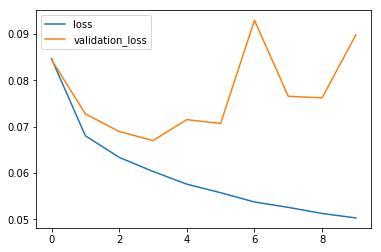

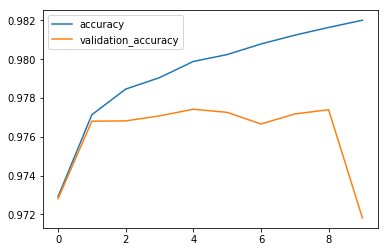

In [32]:
# plot the loss for training data and validation set
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label = 'accuracy')
plt.plot(r.history['val_acc'], label = 'validation_accuracy')
plt.legend()
plt.show()

In [34]:
# calculate the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(len(possible_labels)):
    auc = roc_auc_score(targets[:,j], p[:,j]) # p of size: N x num of labels
    aucs.append(auc)
print(np.mean(aucs))

0.9684481030082573
